In [71]:
import torch 
import matplotlib.pyplot as plt
from models.factory import create_backbone_model
from data.pointnet_data import create_indexed_dataloader
from prototypes.purity_3d import get_3d_purity_fn
from prototypes.utils import compute_channel_activation
from prototypes.selection_3d import generate_3d_prototypes

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
U = torch.load(r'C:\Users\julia\VSCode\ml-splat-xai\outputs\pointnet\orthogonal.pt')['A_raw'].detach().cpu().numpy()

In [23]:
U.shape

(1024, 1024)

(array([4.60000e+01, 1.41400e+03, 2.25180e+04, 1.42874e+05, 3.56924e+05,
        3.57948e+05, 1.42874e+05, 2.25180e+04, 1.41400e+03, 4.60000e+01]),
 array([-0.23511922, -0.18809538, -0.14107153, -0.0940477 , -0.04702385,
         0.        ,  0.04702383,  0.0940477 ,  0.14107153,  0.18809536,
         0.23511922]),
 <BarContainer object of 10 artists>)

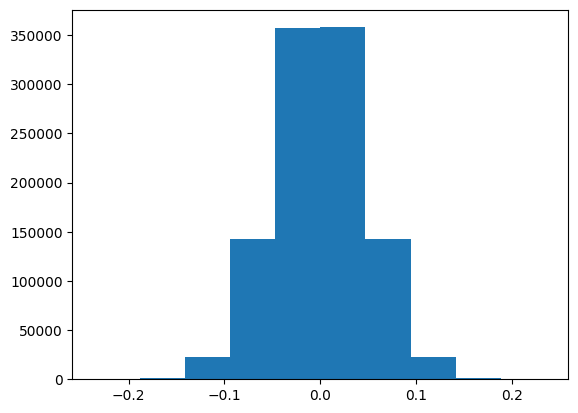

In [24]:
plt.hist(U.flatten())

In [25]:
base_model, feature_model, _, num_channels = create_backbone_model(
    "pointnet2_ssg",
    device,
    r"C:\Users\julia\VSCode\ml-splat-xai\best_model_msg.pt",
    1024,
    8,
    True,
)

In [27]:
dataloader_train = create_indexed_dataloader(
        "../data/train",
        2048,
        16,
        num_workers=4,
        pin_memory=False,
        shuffle=True,
    )

In [28]:
sample = next(iter(dataloader_train))

In [29]:
sample[0].shape, sample[1].shape, sample[2].shape

(torch.Size([16, 2048, 3]), torch.Size([16, 2048, 8]), torch.Size([16]))

In [30]:
xyz = sample[0]
gauss = sample[1]

In [59]:
xyz = xyz.to(device, non_blocking=True)
gauss = gauss.to(device, non_blocking=True)

inputs = torch.cat([xyz, gauss], dim=-1).transpose(1, 2)

feature_map = feature_model(inputs, xyz.transpose(1, 2))

In [60]:
xyz.transpose(1, 2).shape

torch.Size([16, 3, 2048])

In [61]:
inputs.shape

torch.Size([16, 11, 2048])

In [63]:
feature_map.shape

torch.Size([16, 1024, 128])

In [37]:
purity_fn = get_3d_purity_fn("argmax3d")

In [70]:
batch_activations = feature_map.max(dim=-1)[0]
batch_activations.shape

torch.Size([16, 1024])

In [67]:
compute_channel_activation(feature_map)

tensor([[  85.4610,  -28.4832,   30.3440,  ...,  -98.1975,  -43.7500,
          -55.2824],
        [ -47.7584,  -64.8871,  -63.3408,  ...,  -72.5232,  -74.4106,
            0.9344],
        [ -44.6697,  -70.4302,  -58.4819,  ...,  -71.4086, -131.3331,
          -72.2816],
        ...,
        [  21.7167,  -16.4621,   19.0253,  ...,   27.0919,  -71.7436,
          -64.3087],
        [  32.3447,   20.3215,  -53.1188,  ...,  -62.5367, -117.6602,
           -1.3157],
        [ -78.1169,  -88.5256,  -42.7691,  ...,  -46.6464, -119.3227,
          -55.2967]], device='cuda:0')

In [ ]:
positive_prototypes = generate_3d_prototypes(
        feature_model,
        dataloader_train,
        num_channels,
        config.visualization.num_prototypes,
        device,
        disentanglement_matrix(),
    )